## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
import matplotlib.collections as collections
from numpy.fft import fft, ifft, fftshift, fftfreq
import pywt
from scipy import signal
import matplotlib as mpl
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression

## funciones

In [3]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x  

In [4]:
def to_density(z, sal, temp, lat):
    p = gsw.p_from_z(-z, lat)
    rho = gsw.rho_t_exact(sal, temp, p)
    return rho

In [5]:
def earth_to_uv(dfe, dfn, a): 
    "This takes 2 dataframes of east and north coordinates respectively and the regresion coeficient and transforms them to the direction of the coeficient"
    alpha = np.arctan(a) #Ángulo
    t, b = dfe.shape 
    M = np.array([[-np.cos(alpha), np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]]) #Matriz de transfomación
    columns = dfe.columns
    u = np.zeros((0,t)) #Inicialización de variables
    v = np.zeros((0,t)) #Inicialización de variables
    for i in columns: #Iteración sobre las columnas de los dataframes
        bin_ = np.array([[dfe[i].values],
                        [dfn[i].values]]) # Matriz de coordenadas east-north
        ui, vi = np.tensordot(M, bin_, 1) #Multiplicación matricial
        u = np.concatenate((u, ui), axis=0) #Unión de los resultados de u
        v = np.concatenate((v, vi), axis=0)#Unión de los resultados de v
    return u, v

In [6]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [7]:
def spectrum2(h, dt=1, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s

In [8]:
def spectrum3(h, dt=1, nsmooth=5):
    """
    Detrend first.
    """
    t = np.arange(len(h))
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return spectrum2(h_detrended, dt=dt, nsmooth=nsmooth)

In [9]:
def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

def spectrum4(h, dt=1, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    h_detrended = detrend(h)
    
    winweights = quadwin(n)
    h_win = h_detrended * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [10]:
def freq2period(x):
    x = x.astype(float)
    return x ** (-1) / 60


def period2freq(x):
    x = x.astype(float)
    return (x * 60) ** (-1)

# Importar y arreglar datos

In [11]:
# feb16 = xr.open_dataset("data/adcp2012feb.nc")
# newfeb = feb16.sel(time=slice("2012-02-17","2012-03-08"))
adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

UV_burst = xr.open_dataset("data/UV_burst.nc")
EN_burst = xr.open_dataset("data/EastNorth_burst.nc")

In [12]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
# adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [13]:
#Convertir velocidades a DataFrames
columnas = ['bin_1','bin_2','bin_3','bin_4','bin_5','bin_6','bin_7','bin_8','bin_9','bin_10','bin_11','bin_12','bin_13','bin_14','bin_15','bin_16','bin_17','bin_18','bin_19','bin_20','bin_21','bin_22','bin_23','bin_24','bin_25']

df_east = pd.DataFrame(EN_burst.east.values, columns = columnas)
df_east.index = EN_burst.time.values

df_north = pd.DataFrame(EN_burst.north.values, columns = columnas)
df_north.index = EN_burst.time.values

u, v = earth_to_uv(df_east, df_north, 1.13493621)

df_u = pd.DataFrame(np.transpose(u), columns = columnas)
df_u.index = EN_burst.time.values

df_v = pd.DataFrame(np.transpose(v), columns = columnas)
df_v.index = EN_burst.time.values

In [14]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
NM = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
ML = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
PC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

# DC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
# NM = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//NM_ctds_localdates.mat")
# ML = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//AC_ctds_localdates.mat")
# PC = sio.loadmat("C://Users//dhann//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//PC_ctds_localdates.mat")

In [15]:
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
DC_2 = to_data(DC['tdate_dc2'], DC['da_dc2'], DC['s_dc2'], DC['temp_dc2'])
DC_3 = to_data(DC['tdate_dc3'], DC['da_dc3'], DC['s_dc3'], DC['temp_dc3'])
DC_4 = to_data(DC['tdate_dc4'], DC['da_dc4'], DC['s_dc4'], DC['temp_dc4'])

NM_1 = to_data(NM['tdate_nm1'], NM['da_nm1'], NM['s_nm1'], NM['temp_nm1'])
NM_2 = to_data(NM['tdate_nm2'], NM['da_nm2'], NM['s_nm2'], NM['temp_nm2'])
NM_3 = to_data(NM['tdate_nm3'], NM['da_nm3'], NM['s_nm3'], NM['temp_nm3'])

ML_1 = to_data(ML['tdate_ac1'], ML['da_ac1'], ML['s_ac1'], ML['temp_ac1'])
ML_2 = to_data(ML['tdate_ac2'], ML['da_ac2'], ML['s_ac2'], ML['temp_ac2'])

PC_1 = to_data(PC['tdate_pc'], PC['da_pc'], PC['s_pc'], PC['temp_pc'])

In [16]:
#Viento
df2 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120301.dat', sep=",", header=[1, 2, 3])
df2 = pd.DataFrame(df2.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df2 = df2.set_index('TIMESTAMP')
df3 = pd.read_table('C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//meteorological_station//raw//CR200Series_sixmin_pescadero_20120419.dat', sep=",", header=[1, 2, 3])
df3 = pd.DataFrame(df3.values, columns = ['TIMESTAMP','RECORD','Speed','Direction','Winddir_D2','airTC','RH'])
df3 = df3.set_index('TIMESTAMP')
result = pd.concat([df2, df3], ignore_index=False, sort=False)
result.index = pd.to_datetime(result.index)
w = result

In [17]:
north_w = np.float64(w['Speed'])*np.sin(np.pi*np.float64(w['Direction'])/180)
east_w = np.float64(w['Speed'])*np.cos(np.pi*np.float64(w['Direction'])/180)
north_w = pd.DataFrame(data=north_w, columns=['viento'])
east_w = pd.DataFrame(data=east_w, columns=['viento'])

uw, vw = earth_to_uv(east_w, north_w, 0.79970532)

dfw = pd.DataFrame(np.transpose(np.array([uw[0,:], vw[0,:]])), columns=['u', 'v'])
dfw.index = w.index

In [18]:
#Leer datos caudal
Q = pd.read_csv("data\\febmar2012.csv")
lista_nombres= ["nan1", "fecha", "nan2", "sensor", 
                "caudal", "A"]
Q.columns=lista_nombres
Q = Q.drop(columns=['nan1', 'nan2', 'sensor', 'A']).reset_index()
Q = Q.drop(columns=['level_0', 'level_1'])
Q["fecha"] = pd.to_datetime(Q["fecha"].values)

In [19]:
#Importar caudal de pescadero cada 15 min en GMT
# https://nwis.waterservices.usgs.gov/nwis/iv/?sites=11162500&parameterCd=00060&startDT=2011-07-07T00:00:00.000-07:00&endDT=2012-07-07T23:59:59.999-07:00&siteStatus=all&format=rdb
Q = pd.read_csv("data\\caudal2012.csv", sep=';')
Q = Q.drop(['5s', '15s', '14n', 'Unnamed: 6'], axis=1)
Q['index'] = pd.to_datetime(Q['20d'] + ' ' + Q['6s'], format='%d-%m-%Y %H:%M')
Q = Q.set_index('index')
Q = Q.drop(['20d', '6s'], axis=1)

In [20]:
#Importar nivel de agua cada 6 min en hora local
snfco = pd.read_csv("data/CO-OPS_9414290_met.csv")
snfco = snfco.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
snfco['index'] = pd.to_datetime(snfco['Date'] + ' ' + snfco['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
snfco = snfco.set_index('index')
snfco = snfco.drop(['Date', 'Time (LST/LDT)'], axis=1)

mnty = pd.read_csv("data/CO-OPS_9413450_met.csv")
mnty = mnty.drop(['Predicted (m)', 'Preliminary (m)'], axis=1)
mnty['index'] = pd.to_datetime(mnty['Date'] + ' ' + mnty['Time (LST/LDT)'], format='%Y-%m-%d %H:%M')
mnty = mnty.set_index('index')
mnty = mnty.drop(['Date', 'Time (LST/LDT)'], axis=1)

In [21]:
#Importar datos boya 46012 (Half moon bay)
# https://www.ndbc.noaa.gov/station_history.php?station=46012
hmoon = pd.read_csv("data/46012h2012.csv", sep=';', header=0)
hmoon = hmoon.drop(['PRES','TIDE', 'ATMP', 'WTMP','DEWP', 'VIS', 'WDI', 'R WSP', 'D GST'], axis=1)
hmoon = hmoon.drop([0], axis=0)
hmoon['index'] = pd.to_datetime(hmoon['#YY'] + '-' + hmoon['MM'] + '-' + hmoon['DD'] + ' ' + hmoon['hh'] + ':' + hmoon['mm'], format='%Y-%m-%d %H:%M')
hmoon = hmoon.set_index('index')
hmoon = hmoon.drop(['#YY', 'MM', 'DD', 'hh', 'mm'], axis=1)
hmoon['WVHT'] = hmoon['WVHT'].astype('float64')
hmoon['DPD'] = hmoon['DPD'].astype('float64')
hmoon['APD'] = hmoon['APD'].astype('float64')
hmoon['MWD'] = hmoon['MWD'].astype('float64')
hmoon = hmoon.drop([datetime.datetime(2012,2,14,19,50,0), datetime.datetime(2012,2,22,11,50,0), datetime.datetime(2012,2,23,11,50,0)], axis=0)
# WVHT: Significant wave height
# DPD: Dominant wave period (seconds) is the period with the maximum wave energy.
# APD: Average wave period (seconds) of all waves during the 20-minute period. 

In [22]:
#Importar datos de backscatter
bks_drp = np.load("C://Users//Dhannai//Documents//git//dump//bks_drp.npy")
# bks_drp1 = np.load("data/bks_drp1.npy")
# bks_drp2 = np.load("data/bks_drp2.npy")
# bks_drp3 = np.load("data/bks_drp3.npy")
# bks_drp4 = np.load("data/bks_drp4.npy")

## Perfiles

In [23]:
p1 = pd.read_csv("data/perfil1.csv", sep=';')
p1 = p1.drop(['Conductividad', 'Presión', 'Turbidez','Conduct Especifica', 'Density anomaly', 'C'], axis=1)

## Densidad

In [24]:
rho_dc1 = to_density(DC_1['Depth'], DC_1['Salinity'], DC_1['Temperature'], 37.26)
rho_dc2 = to_density(DC_2['Depth'], DC_2['Salinity'], DC_2['Temperature'], 37.26)
rho_dc3 = to_density(DC_3['Depth'], DC_3['Salinity'], DC_3['Temperature'], 37.26)
rho_dc4 = to_density(DC_4['Depth'], DC_4['Salinity'], DC_4['Temperature'], 37.26)

DC_1['densidad'] = rho_dc1
DC_2['densidad'] = rho_dc2
DC_3['densidad'] = rho_dc3
DC_4['densidad'] = rho_dc4

In [25]:
rho_nm1 = to_density(NM_1['Depth'], NM_1['Salinity'], NM_1['Temperature'], 37.26)
rho_nm2 = to_density(NM_2['Depth'], NM_2['Salinity'], NM_2['Temperature'], 37.26)
rho_nm3 = to_density(NM_3['Depth'], NM_3['Salinity'], NM_3['Temperature'], 37.26)

NM_1['densidad'] = rho_nm1
NM_2['densidad'] = rho_nm2
NM_3['densidad'] = rho_nm3

In [26]:
rho_ml1 = to_density(ML_1['Depth'], ML_1['Salinity'], ML_1['Temperature'], 37.26)
rho_ml2 = to_density(ML_2['Depth'], ML_2['Salinity'], ML_2['Temperature'], 37.26)

ML_1['densidad'] = rho_ml1
ML_2['densidad'] = rho_ml2

In [27]:
rho_pc = to_density(PC_1['Depth'], PC_1['Salinity'], PC_1['Temperature'], 37.26)

PC_1['densidad'] = rho_pc

## viento

In [28]:
rho_air = 1.2
cd = 0.0012

dfw = rho_air*cd*dfw*abs(dfw)

## 18 Feb

In [66]:
bu2 = UV_burst.sel(time=slice("2012-02-18 00:00:00","2012-02-19 00:00:00")).u
bv2 = UV_burst.sel(time=slice("2012-02-18 00:00:00","2012-02-19 00:00:00")).v
wdf = dfw['u'].loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
sf = snfco.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
mt = mnty.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
q = Q.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]

dc1 = DC_1.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
dc2 = DC_2.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
dc3 = DC_3.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
dc4 = DC_4.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]

nm1 = NM_1.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
nm2 = NM_2.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
nm3 = NM_3.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]

ml1 = ML_1.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]
ml2 = ML_2.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]

pc1 = PC_1.loc[datetime.datetime(2012,2,18,0,0,0):datetime.datetime(2012,2,19,0,0,0)]

In [30]:
#Función wavelet

t = dc1.index
sig  = dc1['Depth'].values
widths = np.arange(1,31)
coef, freqs = pywt.cwt(sig, widths, 'gaus1')

### Densidades y viento

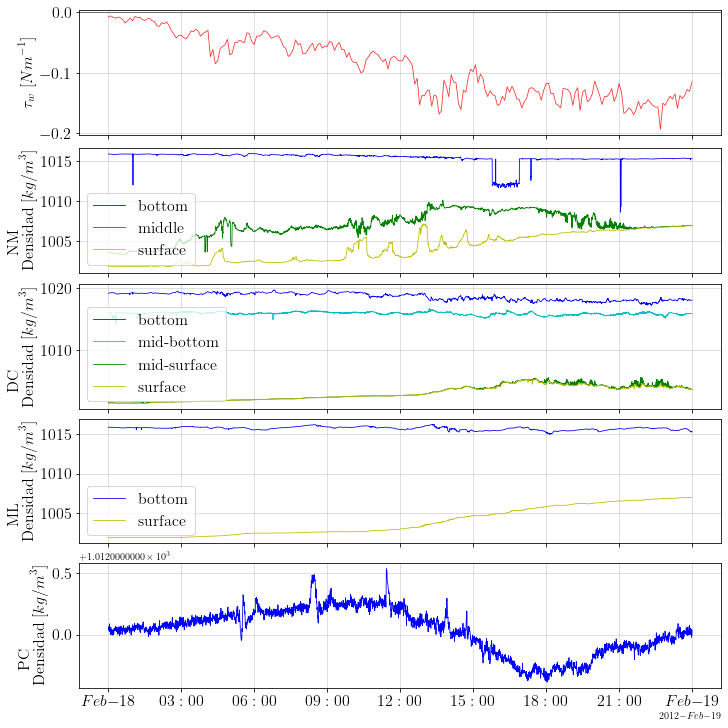

In [31]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(10, 10), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)


#Esfuerzo de viento
ax1.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax1.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

##Grafico de densidad NM
ax2.set_ylabel(r"NM\\Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=16)
ax2.plot(nm1.index, nm1['densidad'], linewidth=0.8, c="b", label='bottom')
ax2.plot(nm2.index, nm2['densidad'], linewidth=0.8, c="g", label='middle')
ax2.plot(nm3.index, nm3['densidad'], linewidth=0.8, c="y", label='surface')
ax2.legend(loc='lower left',
          fontsize=16);
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

#Grafico de densidad DC
ax3.set_ylabel(r"DC\\Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=16)
ax3.plot(dc1.index, dc1['densidad'], linewidth=0.8, c="b", label='bottom')
ax3.plot(dc2.index, dc2['densidad'], linewidth=0.8, c="c", label='mid-bottom')
ax3.plot(dc3.index, dc3['densidad'], linewidth=0.8, c="g", label='mid-surface')
ax3.plot(dc4.index, dc4['densidad'], linewidth=0.8, c="y", label='surface')

ax3.legend(loc='lower left',
          fontsize=16);
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

#Grafico de densidad ML
ax4.set_ylabel(r"ML\\Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=16)
ax4.plot(ml1.index, ml1['densidad'], linewidth=0.8, c="b", label='bottom')
ax4.plot(ml2.index, ml2['densidad'], linewidth=0.8, c="y", label='surface')
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

ax4.legend(loc='lower left',
          fontsize=16);

#Grafico de densidad PC

ax5.set_ylabel(r"PC\\Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=16)
ax5.plot(pc1.index, pc1['densidad'], linewidth=0.8, c="b", label='bottom')
ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)
# ax5.ticklabel_format(style='plain')



# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

- Comentario: Se observa caíada en al densidad en el fondo de PC junto con al aumento de la velocidad onshore del viento. También se observa aumentops de la densidad en la superficie de los demas sensores pero no mucho cambio en el fondo. Parece que disminuye la densidad

### Caudal

#### NM

In [32]:
#dh/dt

hf = nm1['Depth'].values[360:]
hi = nm1['Depth'].values[:-360]
dt = 1

dhdt = (hf-hi)/dt

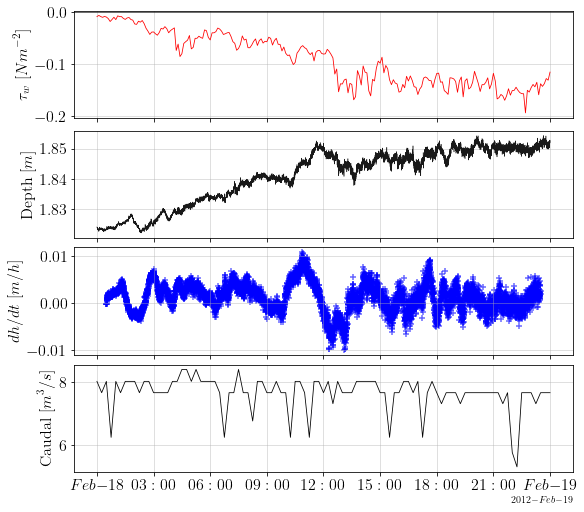

In [33]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax1, ax3, ax10) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.plot(nm1.index, nm1['Depth'].values, c='k', alpha=0.9, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax3.set_ylabel(r"$dh/dt$ "
          r"$\displaystyle[m/h]$",
          fontsize=16)
ax3.scatter(nm1.index[180:-180], dhdt, color='b', marker='+', alpha=0.6)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax10.set_ylabel(r"Caudal "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax10.plot(q.index, q, lw=0.8, c='k')

ax10.xaxis.set_tick_params(labelsize=16)
ax10.yaxis.set_tick_params(labelsize=16)
ax10.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

#### DC

In [42]:
#dh/dt

hf = dc1['Depth'].values[360:]
hi = dc1['Depth'].values[:-360]
dt = 1

dhdt = (hf-hi)/dt

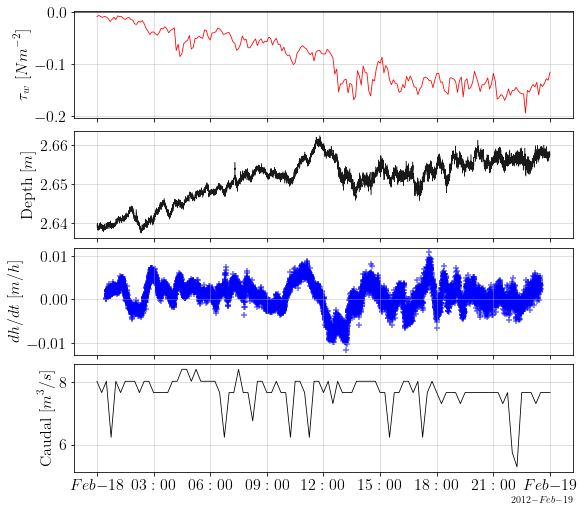

In [43]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax1, ax3, ax10) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.9, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax3.set_ylabel(r"$dh/dt$ "
          r"$\displaystyle[m/h]$",
          fontsize=16)
ax3.scatter(dc1.index[180:-180], dhdt, color='b', marker='+', alpha=0.6)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax10.set_ylabel(r"Caudal "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax10.plot(q.index, q, lw=0.8, c='k')

ax10.xaxis.set_tick_params(labelsize=16)
ax10.yaxis.set_tick_params(labelsize=16)
ax10.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

#### ML

In [40]:
#dh/dt

hf = ml1['Depth'].values[360:]
hi = ml1['Depth'].values[:-360]
dt = 1

dhdt = (hf-hi)/dt

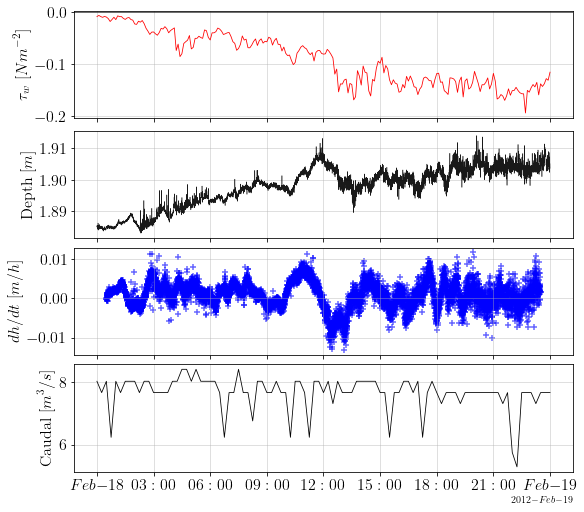

In [41]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax1, ax3, ax10) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.plot(ml1.index, ml1['Depth'].values, c='k', alpha=0.9, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax3.set_ylabel(r"$dh/dt$ "
          r"$\displaystyle[m/h]$",
          fontsize=16)
ax3.scatter(ml1.index[180:-180], dhdt, color='b', marker='+', alpha=0.6)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax10.set_ylabel(r"Caudal "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax10.plot(q.index, q, lw=0.8, c='k')

ax10.xaxis.set_tick_params(labelsize=16)
ax10.yaxis.set_tick_params(labelsize=16)
ax10.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

#### PC

In [38]:
#dh/dt

hf = pc1['Depth'].values[120:]
hi = pc1['Depth'].values[:-120]
dt = 1

dhdt = (hf-hi)/dt

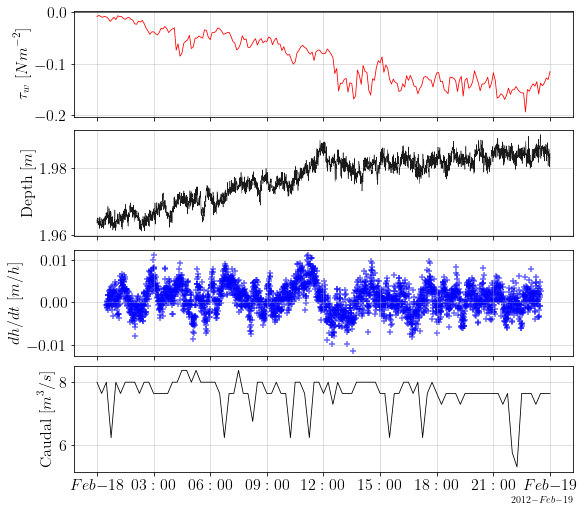

In [39]:
#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax2, ax1, ax3, ax10) = plt.subplots(nrows=4, figsize=(8, 7), constrained_layout=True, sharex=True)

ax2.set_ylabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax2.plot(wdf.index, wdf.values,color='r', linewidth=0.8)
ax2.axhline(y=0, color='k', linewidth=0.5)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax1.set_ylabel(r"Depth "
          r"$\displaystyle[m]$",
          fontsize=16)
ax1.plot(pc1.index, pc1['Depth'].values, c='k', alpha=0.9, linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax3.set_ylabel(r"$dh/dt$ "
          r"$\displaystyle[m/h]$",
          fontsize=16)
ax3.scatter(pc1.index[60:-60], dhdt, color='b', marker='+', alpha=0.6)
# ax3.axhline(y=0, color='k', linewidth=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)


ax10.set_ylabel(r"Caudal "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax10.plot(q.index, q, lw=0.8, c='k')

ax10.xaxis.set_tick_params(labelsize=16)
ax10.yaxis.set_tick_params(labelsize=16)
ax10.grid(alpha=0.5)

ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

### Densidades

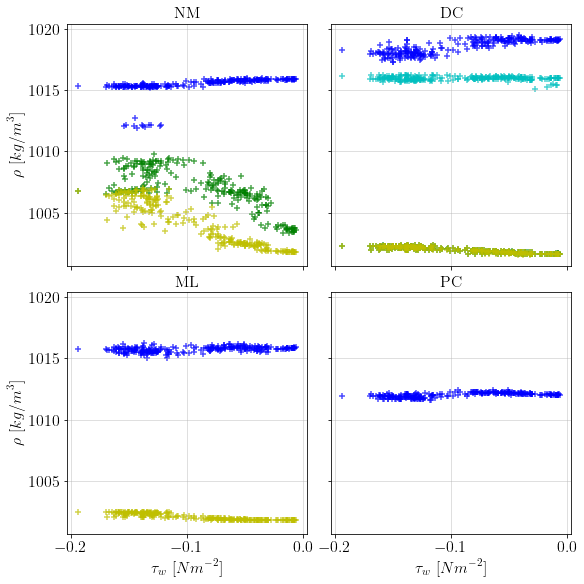

In [45]:
i_nm1 = np.linspace(0, len(nm1)-1, num=len(wdf)).astype(int)
i_nm2 = np.linspace(0, len(nm2)-1, num=len(wdf)).astype(int)
i_pc1 = np.linspace(0, len(pc1)-1, num=len(wdf)).astype(int)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), constrained_layout=True, sharex=True, sharey=True)

ax1.set_title(r"NM",
          fontsize=16)
ax1.set_ylabel(r"$\rho$ "
          r"$\displaystyle[kg/m^{3}]$",
          fontsize=16)
ax1.scatter(wdf.values, nm1['densidad'].iloc[i_nm1], color='b', marker='+', alpha=0.7)
ax1.scatter(wdf.values, nm2['densidad'].iloc[i_nm2], color='g', marker='+', alpha=0.7)
ax1.scatter(wdf.values, nm3['densidad'].iloc[i_nm2], color='y', marker='+', alpha=0.7)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

ax2.set_title(r"DC",
          fontsize=16)
ax2.scatter(wdf.values, dc1['densidad'].iloc[i_nm1], color='b', marker='+', alpha=0.7)
ax2.scatter(wdf.values, dc2['densidad'].iloc[i_nm2], color='c', marker='+', alpha=0.7)
ax2.scatter(wdf.values, dc3['densidad'].iloc[i_nm2], color='g', marker='+', alpha=0.7)
ax2.scatter(wdf.values, dc4['densidad'].iloc[i_nm2], color='y', marker='+', alpha=0.7)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

ax3.set_title(r"ML",
          fontsize=16)
ax3.set_xlabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax3.set_ylabel(r"$\rho$ "
          r"$\displaystyle[kg/m^{3}]$",
          fontsize=16)
ax3.scatter(wdf.values, ml1['densidad'].iloc[i_nm1], color='b', marker='+', alpha=0.7)
ax3.scatter(wdf.values, ml2['densidad'].iloc[i_nm2], color='y', marker='+', alpha=0.7)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_title(r"PC",
          fontsize=16)
ax4.set_xlabel(r"$\tau_{w}$ "
          r"$\displaystyle[Nm^{-2}]$",
          fontsize=16)
ax4.scatter(wdf.values, pc1['densidad'].iloc[i_pc1], color='b', marker='+', alpha=0.7)
ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)

__Comentario:__ Densidad en capa profunda disminuye a medida que el corte del viento aumenta, y densidad en las capas más superficiales aumentan a medida que el viento aumenta.

### Cuantificar mezcla
#### NM

In [46]:
g = 9.81 # m/s^2

rho1 = nm1.loc[nm3.index]['densidad'].values
rho2 = nm2['densidad'].values
rho3 = nm3['densidad'].values
z1 = nm1.loc[nm3.index]['Depth'].values
z2 = nm2['Depth'].values
z3 = nm3['Depth'].values

### Potential energy anomaly

# Discretizacion 1
nm_rho_hat = (rho1*(z1 - z2)
              + rho2*(z2 - z3) 
              + rho3*z3)/z1

nm_pot = (g/(2*z1))*((rho3 - rho2)*(z3)**2
                     + (rho2 - rho1)*(z2)**2
                     + (rho1 - nm_rho_hat)*z1**2)

# 
# # Discretizacion 2
# nm_rho_hat = (0.5*rho1*(z1 - z2)
#               + 0.5*rho2*(z1 - z3) 
#               + 0.5*rho3*(z3 + z2))/z1

# nm_pot = (g/(2*z1))*(0.25*(rho3 - rho2)*(z3 + z2)**2 
#                                                   + 0.25*(rho2 - rho1)*(z2 + z1)**2 
#                                                   + (rho1 - nm_rho_hat)*(z1)**2)

nm_phi = pd.DataFrame(nm_pot,
                  index = nm3.index,
                  columns = ['potential_anomaly'])

### Buoyancy frequency

nm32_N2 = (g/(0.5*(rho3 + rho2)))*((rho3-rho2)/(z3-z2))
nm21_N2 = (g/(0.5*(rho2 + rho1)))*((rho2-rho1)/(z2-z1))
nm31_N2 = (g/(0.5*(rho3 + rho1)))*((rho3-rho1)/(z3-z1))

N2_nm32 = pd.DataFrame(nm32_N2,
                  index = nm3.index,
                  columns = ['N2 3-2'])

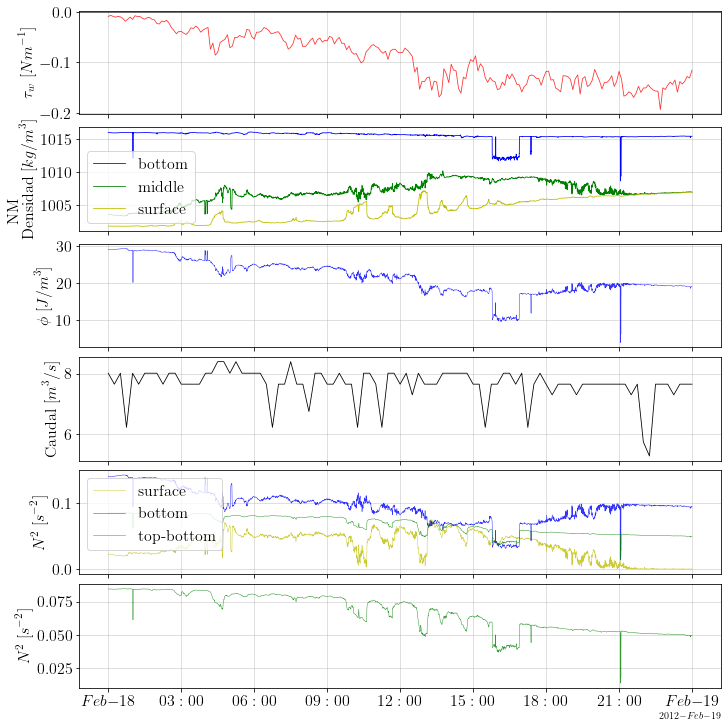

In [48]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, figsize=(10, 10), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) NM

#Esfuerzo de viento
ax1.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax1.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

##Grafico de densidad NM
ax2.set_ylabel(r"NM\\Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=16)
ax2.plot(nm1.index, nm1['densidad'], linewidth=0.8, c="b", label='bottom')
ax2.plot(nm2.index, nm2['densidad'], linewidth=0.8, c="g", label='middle')
ax2.plot(nm3.index, nm3['densidad'], linewidth=0.8, c="y", label='surface')
ax2.legend(loc='lower left',
          fontsize=16);
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# #Grafico de densidad DC
# ax3.set_ylabel(r"DC\\Densidad "
#           r"$\displaystyle[kg/m^3]$",
#           fontsize=16)
# ax3.plot(dc1.index, dc1['densidad'], linewidth=0.8, c="b", label='bottom')
# ax3.plot(dc2.index, dc2['densidad'], linewidth=0.8, c="c", label='mid-bottom')
# ax3.plot(dc3.index, dc3['densidad'], linewidth=0.8, c="g", label='mid-surface')
# ax3.plot(dc4.index, dc4['densidad'], linewidth=0.8, c="y", label='surface')

# ax3.legend(loc='lower left',
#           fontsize=16);
# ax3.xaxis.set_tick_params(labelsize=16)
# ax3.yaxis.set_tick_params(labelsize=16)
# ax3.grid(alpha=0.5)

# #Grafico de densidad ML
# ax4.set_ylabel(r"ML\\Densidad "
#           r"$\displaystyle[kg/m^3]$",
#           fontsize=16)
# ax4.plot(ml1.index, ml1['densidad'], linewidth=0.8, c="b", label='bottom')
# ax4.plot(ml2.index, ml2['densidad'], linewidth=0.8, c="y", label='surface')
# ax4.xaxis.set_tick_params(labelsize=16)
# ax4.yaxis.set_tick_params(labelsize=16)
# ax4.grid(alpha=0.5)

# ax4.legend(loc='lower left',
#           fontsize=16);

# #Grafico de densidad PC

# ax5.set_ylabel(r"PC\\Densidad "
#           r"$\displaystyle[kg/m^3]$",
#           fontsize=16)
# ax5.plot(pc1.index, pc1['densidad'], linewidth=0.8, c="b", label='bottom')
# ax5.xaxis.set_tick_params(labelsize=16)
# ax5.yaxis.set_tick_params(labelsize=16)
# ax5.grid(alpha=0.5)
# # ax5.ticklabel_format(style='plain')

ax3.set_ylabel(r"$\phi$ "
          r"$\displaystyle[J/m^3]$",
          fontsize=16)

ax3.plot(nm3.index, nm_pot, c='b', alpha=0.8, linewidth=0.5)

ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Caudal "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax4.plot(q.index, q, lw=0.8, c='k')

ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


ax5.set_ylabel(r"$N^2$ "
          r"$\displaystyle[s^{-2}]$",
          fontsize=16)

ax5.plot(nm3.index, nm32_N2, c='y', alpha=0.8, linewidth=0.5, label='surface')
ax5.plot(nm3.index, nm21_N2, c='b', alpha=0.8, linewidth=0.5, label='bottom')
ax5.plot(nm3.index, nm31_N2, c='g', alpha=0.8, linewidth=0.5, label='top-bottom')

ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)
ax5.legend(loc='upper left', fontsize=16)
# ax5.set_ylim(-24, -22)

ax6.set_ylabel(r"$N^2$ "
          r"$\displaystyle[s^{-2}]$",
          fontsize=16)

# ax6.plot(nm3.index, nm32_N2, c='y', alpha=0.8, linewidth=0.5, label='surface')
# ax6.plot(nm3.index, nm21_N2, c='b', alpha=0.8, linewidth=0.5, label='bottom')
ax6.plot(nm3.index, nm31_N2, c='g', alpha=0.8, linewidth=0.5, label='top-bottom')

ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
# ax6.legend(loc='upper left', fontsize=16)

# ax7.set_ylabel(r"$Ri$ ",
#           fontsize=16)

# ax7.plot(bu2_time, nm32_ri, c='b', alpha=0.8, linewidth=0.5, label='top-bottom')

# ax7.xaxis.set_tick_params(labelsize=16)
# ax7.yaxis.set_tick_params(labelsize=16)
# ax7.grid(alpha=0.5)
# ax7.axhline(y=0.25, color='r', linewidth=0.5)
# ax7.set_ylim(0, 0.3)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)

#### DC

In [49]:
g = 9.81 # m/s^2

rho1 = dc1['densidad'].values
rho2 = dc2['densidad'].values
rho3 = dc3['densidad'].values
rho4 = dc4['densidad'].values
z1 = dc1['Depth'].values
z2 = dc2['Depth'].values
z3 = dc3['Depth'].values
z4 = dc4['Depth'].values

# Discretizacion 1
dc_rho_hat = (rho1*(z1 - z2)
              + rho2*(z2 - z3) 
              + rho3*(z3 - z4)
              + rho4*z4)/z1

dc_pot = (g/(2*z1))*((rho4 - rho3)*(z4)**2 
                     + (rho3 - rho2)*(z3)**2
                     + (rho2 - rho1)*(z2)**2
                     + (rho1 - dc_rho_hat)*z1**2)


# # Discretizacion 2
# dc_rho_hat = (0.5*rho1*(z1 - z2)
#               + 0.5*rho2*(z1 - z3) 
#               + 0.5*rho3*(z2 - z4)
#               + 0.5*rho4*(z4 + z3))/z1

# dc_pot = (g/(2*z1))*(0.25*(rho4 - rho3)*(z4 + z3)**2 
#                      + 0.25*(rho3 - rho2)*(z3 + z2)**2
#                      + 0.25*(rho2 - rho1)*(z2 + z1)**2
#                      + (rho1 - dc_rho_hat)*z1**2)

dc_phi = pd.DataFrame(dc_pot,
                  index = dc3.index,
                  columns = ['potential_anomaly'])

### Buoyancy frequency

dc43_N2 = (g/(0.5*(rho4 + rho3)))*((rho4-rho3)/(z4-z3))
dc21_N2 = (g/(0.5*(rho2 + rho1)))*((rho2-rho1)/(z2-z1))
dc41_N2 = (g/(0.5*(rho4 + rho1)))*((rho4-rho1)/(z4-z1))

N2_dc43 = pd.DataFrame(dc43_N2,
                  index = dc3.index,
                  columns = ['N2'])

In [69]:
### Richardson number

bu2_time = bu2.time.values
bu2_time = np.delete(bu2_time, [3, 133])
h_u = dc1.loc[bu2_time]['Depth'].values

bv2_time = bv2.time.values
bv2_time = np.delete(bv2_time, [3, 133])
# h_v = dc1.loc[bv2_time]['Depth'].values

tiempo, bins = np.meshgrid(bu2_time, bu2.bin.values[:8])
# tiempo, bins_v = np.meshgrid(bv2_time, bv2.bin.values[:8])

bins2 = np.zeros((bins.shape))
for i in range(8):
    bins2[i,:] = h_u - bins[i, :]

# bins2_v = np.zeros((bins_v.shape))
# for i in range(8):
#     bins2_v[i,:] = h_v - bins_v[i, :]

dudz = ((bu2.isel(bin=5).sel(time=bu2_time).values - bu2.isel(bin=1).sel(time=bu2_time).values)/(bins2[5,:]-bins2[1,:]))
dvdz = ((bv2.isel(bin=5).sel(time=bu2_time).values - bv2.isel(bin=1).sel(time=bu2_time).values)/(bins2[5,:]-bins2[1,:]))

S2 = dudz**2 + dvdz**2

dc43_ri = N2_dc43['N2'].loc[bu2_time].values/S2

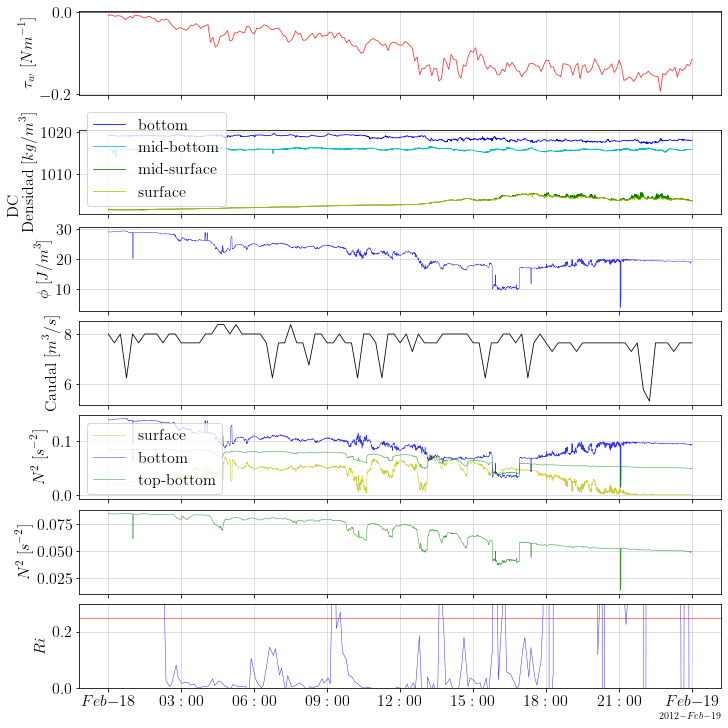

In [71]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, figsize=(10, 10), constrained_layout=True, sharex=True)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Grafico de profundidad y densidad (color map) NM

#Esfuerzo de viento
ax1.set_ylabel(r"$\tau_w$ "
          r"$\displaystyle[Nm^{-1}]$",
          fontsize=16)
ax1.plot(wdf.index, wdf.values, color='r', alpha=0.8, linewidth=0.8, label='u')
ax1.axhline(y=0, color='k', linewidth=0.5)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.grid(alpha=0.5)

#Grafico de densidad DC
ax2.set_ylabel(r"DC\\Densidad "
          r"$\displaystyle[kg/m^3]$",
          fontsize=16)
ax2.plot(dc1.index, dc1['densidad'], linewidth=0.8, c="b", label='bottom')
ax2.plot(dc2.index, dc2['densidad'], linewidth=0.8, c="c", label='mid-bottom')
ax2.plot(dc3.index, dc3['densidad'], linewidth=0.8, c="g", label='mid-surface')
ax2.plot(dc4.index, dc4['densidad'], linewidth=0.8, c="y", label='surface')

ax2.legend(loc='lower left',
          fontsize=16);
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.grid(alpha=0.5)

# #Grafico de densidad ML
# ax4.set_ylabel(r"ML\\Densidad "
#           r"$\displaystyle[kg/m^3]$",
#           fontsize=16)
# ax4.plot(ml1.index, ml1['densidad'], linewidth=0.8, c="b", label='bottom')
# ax4.plot(ml2.index, ml2['densidad'], linewidth=0.8, c="y", label='surface')
# ax4.xaxis.set_tick_params(labelsize=16)
# ax4.yaxis.set_tick_params(labelsize=16)
# ax4.grid(alpha=0.5)

# ax4.legend(loc='lower left',
#           fontsize=16);

# #Grafico de densidad PC

# ax5.set_ylabel(r"PC\\Densidad "
#           r"$\displaystyle[kg/m^3]$",
#           fontsize=16)
# ax5.plot(pc1.index, pc1['densidad'], linewidth=0.8, c="b", label='bottom')
# ax5.xaxis.set_tick_params(labelsize=16)
# ax5.yaxis.set_tick_params(labelsize=16)
# ax5.grid(alpha=0.5)
# # ax5.ticklabel_format(style='plain')

ax3.set_ylabel(r"$\phi$ "
          r"$\displaystyle[J/m^3]$",
          fontsize=16)

ax3.plot(nm3.index, nm_pot, c='b', alpha=0.8, linewidth=0.5)

ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.grid(alpha=0.5)

ax4.set_ylabel(r"Caudal "
          r"$\displaystyle[m^3/s]$",
          fontsize=16)
ax4.plot(q.index, q, lw=0.8, c='k')

ax4.xaxis.set_tick_params(labelsize=16)
ax4.yaxis.set_tick_params(labelsize=16)
ax4.grid(alpha=0.5)


ax5.set_ylabel(r"$N^2$ "
          r"$\displaystyle[s^{-2}]$",
          fontsize=16)

ax5.plot(nm3.index, nm32_N2, c='y', alpha=0.8, linewidth=0.5, label='surface')
ax5.plot(nm3.index, nm21_N2, c='b', alpha=0.8, linewidth=0.5, label='bottom')
ax5.plot(nm3.index, nm31_N2, c='g', alpha=0.8, linewidth=0.5, label='top-bottom')

ax5.xaxis.set_tick_params(labelsize=16)
ax5.yaxis.set_tick_params(labelsize=16)
ax5.grid(alpha=0.5)
ax5.legend(loc='upper left', fontsize=16)
# ax5.set_ylim(-24, -22)

ax6.set_ylabel(r"$N^2$ "
          r"$\displaystyle[s^{-2}]$",
          fontsize=16)

# ax6.plot(nm3.index, nm32_N2, c='y', alpha=0.8, linewidth=0.5, label='surface')
# ax6.plot(nm3.index, nm21_N2, c='b', alpha=0.8, linewidth=0.5, label='bottom')
ax6.plot(nm3.index, nm31_N2, c='g', alpha=0.8, linewidth=0.5, label='top-bottom')

ax6.xaxis.set_tick_params(labelsize=16)
ax6.yaxis.set_tick_params(labelsize=16)
ax6.grid(alpha=0.5)
# ax6.legend(loc='upper left', fontsize=16)

ax7.set_ylabel(r"$Ri$ ",
          fontsize=16)

ax7.plot(bu2_time, dc43_ri, c='b', alpha=0.8, linewidth=0.5, label='top-bottom')

ax7.xaxis.set_tick_params(labelsize=16)
ax7.yaxis.set_tick_params(labelsize=16)
ax7.grid(alpha=0.5)
ax7.axhline(y=0.25, color='r', linewidth=0.5)
ax7.set_ylim(0, 0.3)

# Ajustar formato fecha
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)